In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Kaidong, Wu (1457721)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I built a neural network as the question description. The activation function of hidden layers are "relu", it is in most cases the default option, "softmax" is the activation function of output layer because the output values, can be seen as the "probability", thus ideal for classification problem. The model performs well without overfitting according to the plot.  (length: 368)



Max val score: 74.82%


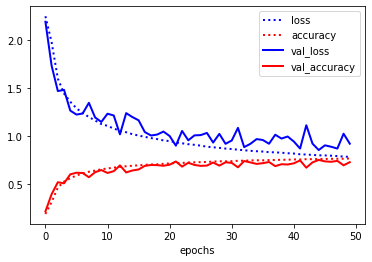

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                260       
Total params: 313,885
Trainable params: 313,885
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



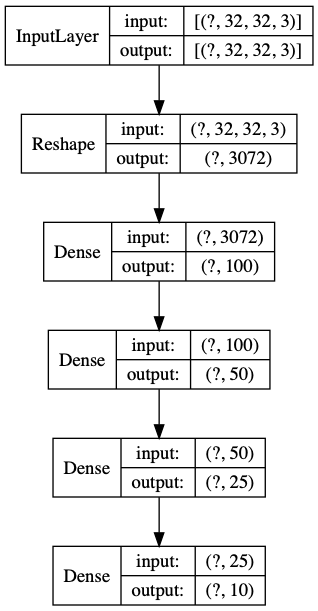

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

I convert the RGB images to greyscale and retrain the model. The input shape is (32,32,1) now, and needed to reshape to (1024,), other parameters are exactly the same as 1.1. The result shows that greyscale images has better performance than RGB images. This implies that the label of digits depends on its shapes, not colors. The color may even disturb performance. That's maybe because light may blur images and make it difficult for classification.  (length: 453)



Max val score: 77.09%


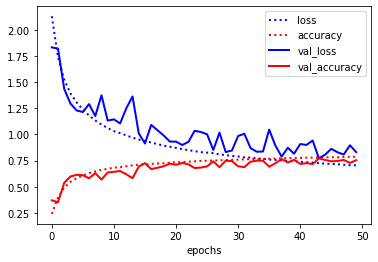

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                260       
Total params: 109,085
Trainable params: 109,085
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Since there are no overfitting occurs in 1.1 and 1.2, regularization methods like L1,L2 regularization and dropout do not help(I've tried those methods, they are indeed lower the performance a little). So I only use batch normalization, which increase the "capacity" of nerual network. The result shows that batch normalization increase val accuracy by 1%.  (length: 358)



Max val score: 78.69%


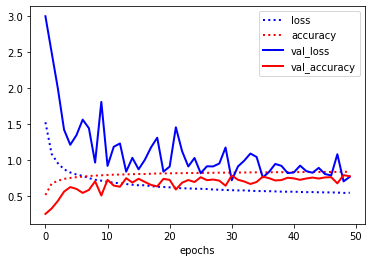

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I construct a VGG-like model(I remove a maxpooling layer for the size reason), at first setting, the model overfits begins from about 15 epochs. Then I use an common approach used in the lab that gradually increase the amount of dropout and add batchnormalizations after dense layer. The accuracy reachs 95% without overfitting.  (length: 330)



Max val score: 95.20%


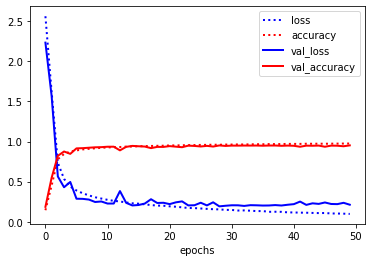

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 28, 28, 64)        18496     
_________________________________________________________________
dropout_62 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 26, 26, 128)       73856     
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 12, 12, 128)     

def build_model_2_1():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))  
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
              loss='c

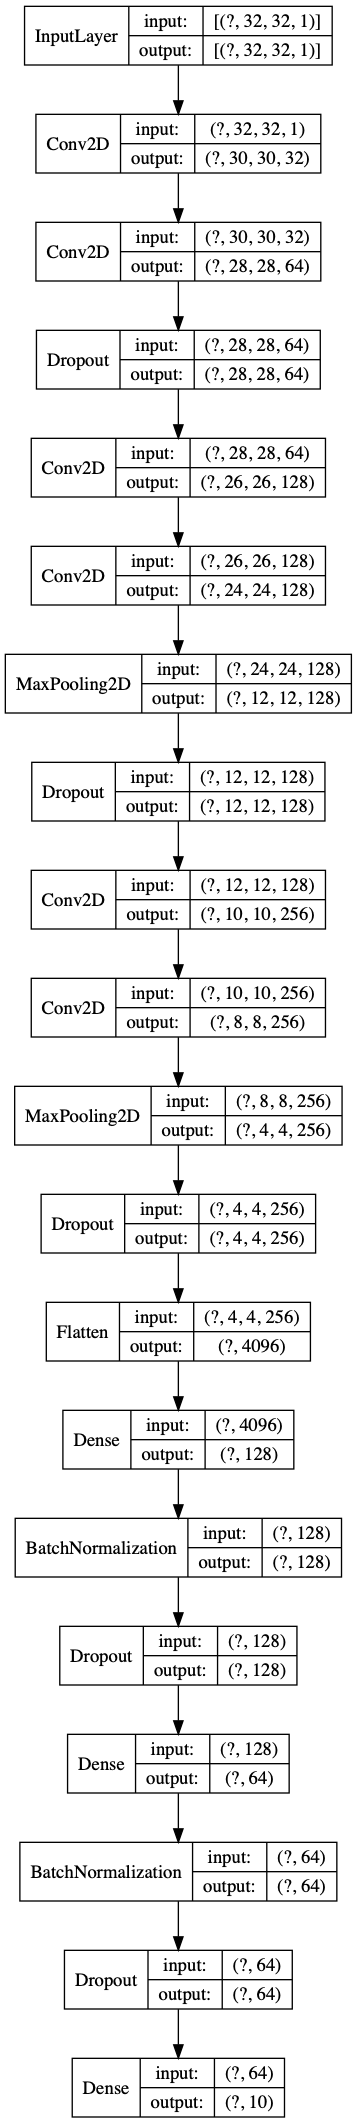

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

I've tried many combination of parameters, only a few of them improve performance. Some parameters even lower performance like shear=0.5. The idea is that we should make sure augmented data is reasonable in real life. (For example, we don’t often encounter horizontally flipped numbers) The parameters in the code that very subtle augment data imporves accuracy a little bit (less than 1%).  (length: 392)



Max val score: 95.69%


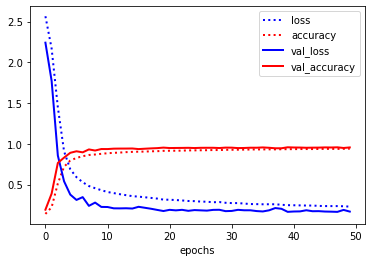


train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    rotation_range=15)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

As we can see in the confusion matrix, class 7 is often misclassified. So I plot 25 misclassified samples that have a actual label of 7 to see what kind of mistake are made. The main reason for misclassification is that some figures are too close in shape, like 1 and 7, even human makes this mistake. Also, there are other types of mistakes such as two or more figures appears together and the classifier is attracted by the other figure.  (length: 441)

Test score: 0.95%


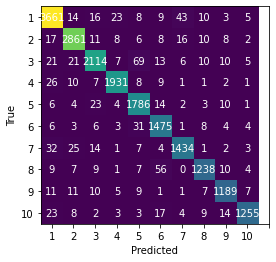

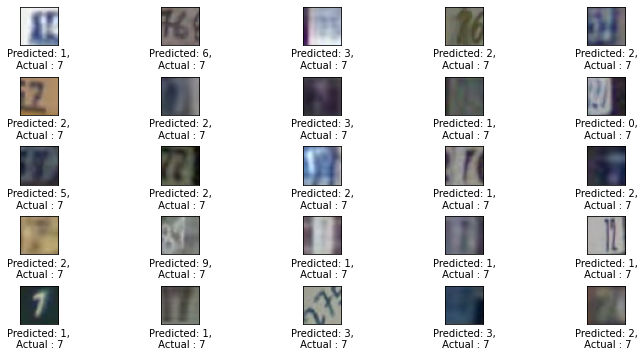

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

The activations of first layer keep the shape of original digits. There are about a half activations are left blank, this means no features are caputered by these filters. The activations become more abstract as we go deeper into the layers. This is because higher level layers begin to capture higher level features by combining lower level features. As we can see in the last several layers, the activations are mainly basic geometric elements such as curves, dots and lines.    (length: 481)



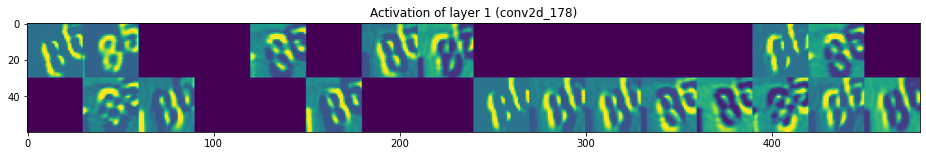

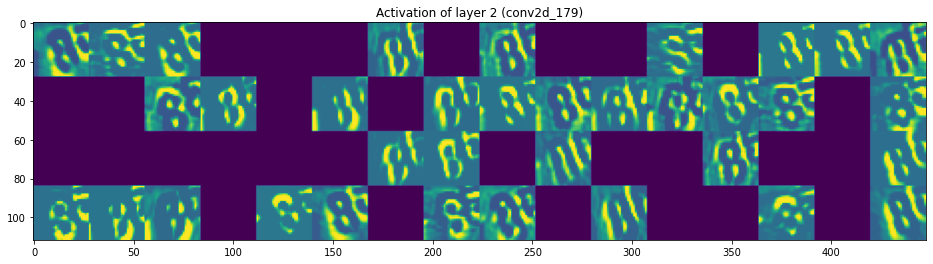

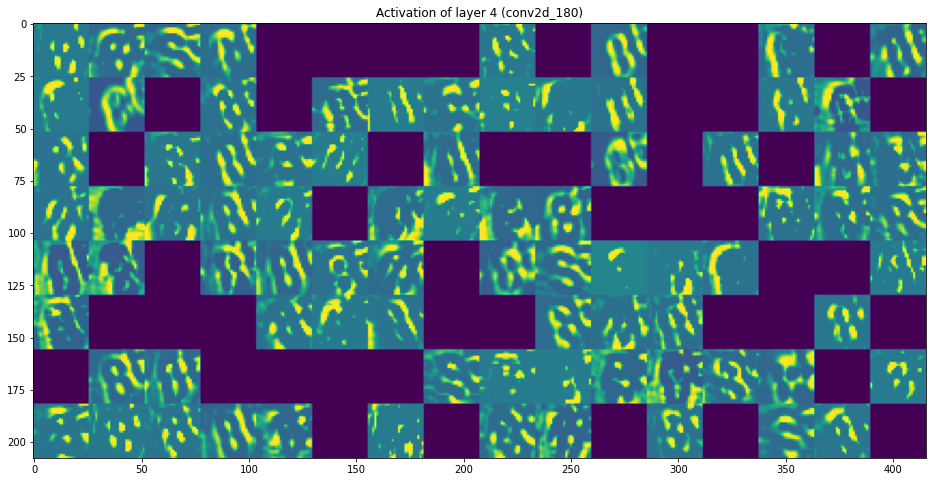

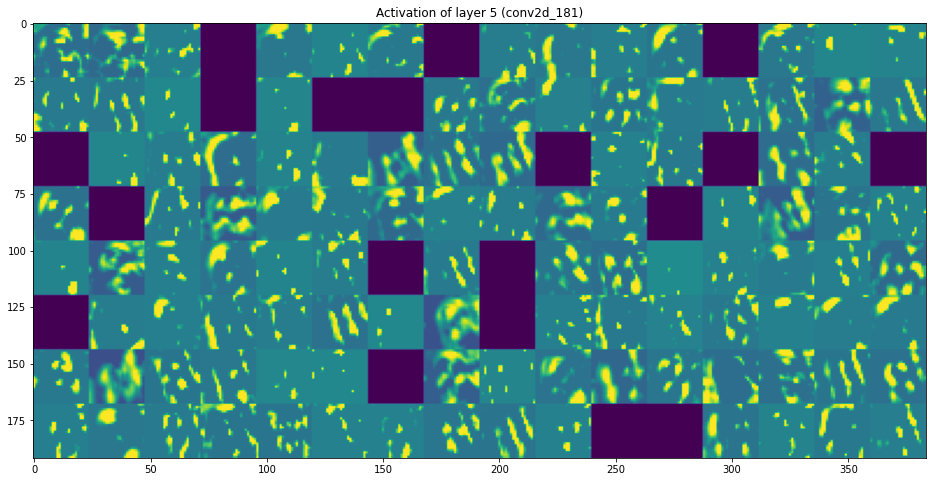

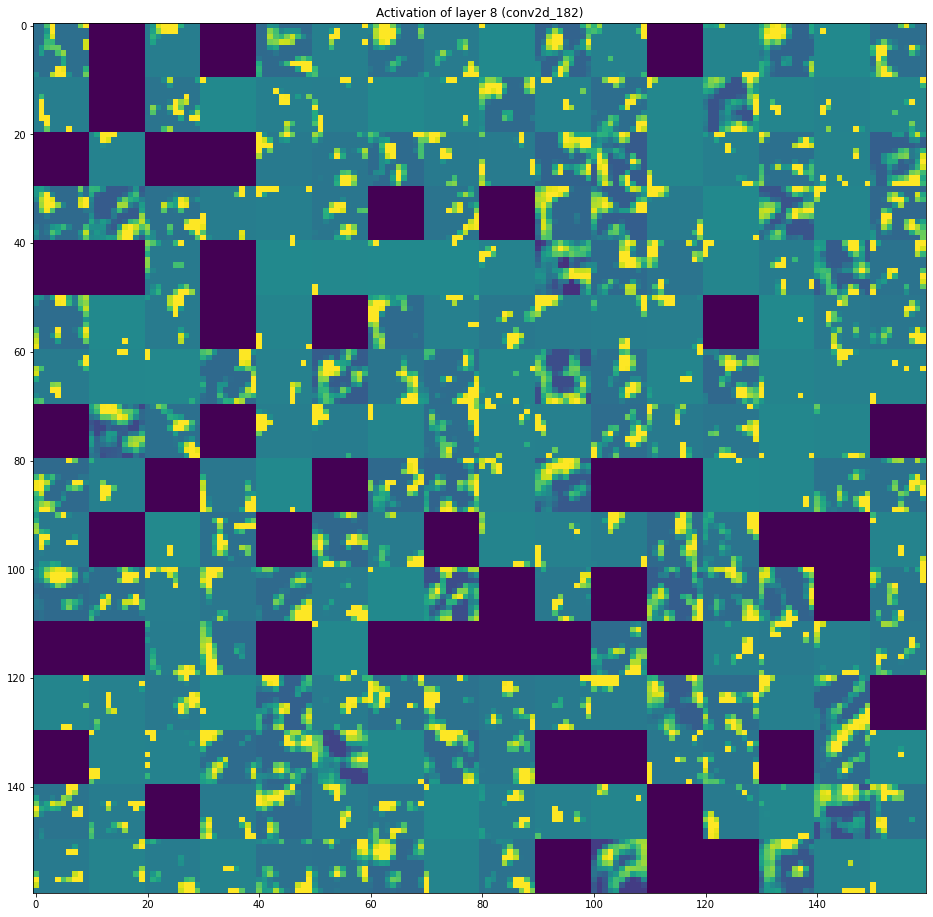

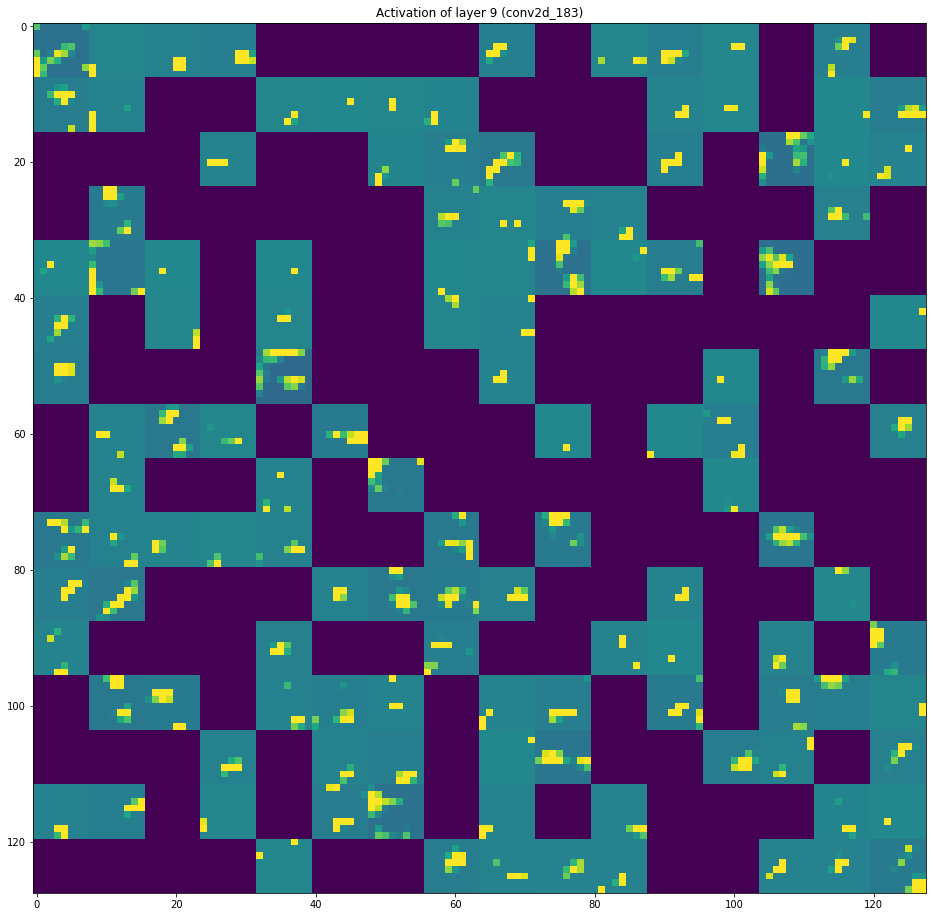

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

ERROR, could not build class activation plot. Please check original report
def plot_activation_map():
    #fig, axes = plt.subplots(1, 1,  figsize=(10, 5))
    x = rgb2gray(X_test)[0]
    x = np.expand_dims(x,axis=0)
    pred = model.predict(x)
    class_idx = np.argmax(pred[0])
    class_output = model.output[:,class_idx]
    last_conv_layer = model.layers[8]
    grads = K.gradients(class_output,last_conv_layer.output)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(256):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]           
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    plt.imshow(heatmap)
    plt.show()
    plt.cla() 
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

The accuracy is approximately 65% if all convolution layers are freezed in vgg16. If we enable two convolutional layers(which is block 1), we get an accuracy 84.3%. Obviously, unfreeze convolutional layers makes performance better.  (length: 233)



Max val score: 84.31%


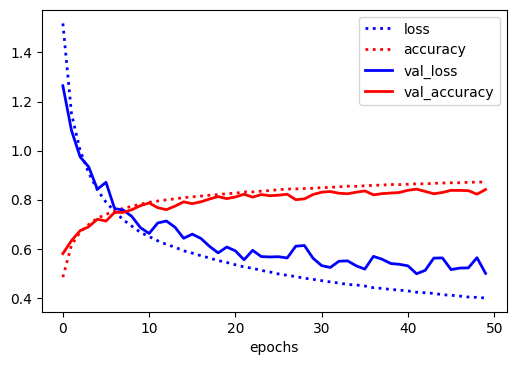

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 72,202
Non-trainable params: 14,675,968
_________________________________________________________________
None


def build_model_4_1():
    model = models.Sequential()
    model.add(VGG16(include_top = False, weights = 'imagenet', input_shape=(32, 32, 3), pooling='max'))
    #model.summary()
    
    for i in con_layer_index[2:13]:    
        layer = model.layers[0].layers[i]
        layer.trainable = False
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop' ,loss='categorical_crossentropy',metrics=['accuracy'])
    return model



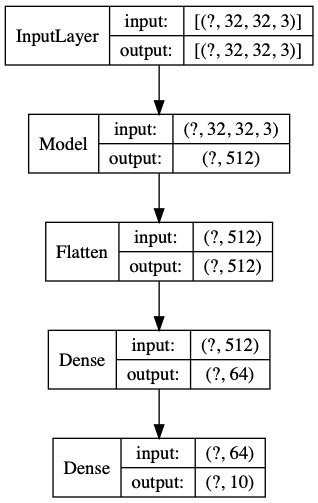

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I use randomforestrwithout scaler. The score is 0.70, which is far from the best model. That's may be because in 4.1, I only unfreeze 2 convolutional layers. If more(or all) con layers are unfreezed, the performance would be better. But it takes a lot of time to retrain the model, so I skip it.  (length: 297)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=1))])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  vgg16_conv_layers = model.get_layer('vgg16')
  train = vgg16_conv_layers.predict(X_train_all)
  train = train.reshape(train.shape[0], 512)
  test = vgg16_conv_layers.predict(X_test)
  test = test.reshape(test.shape[0], 512)
  store_embedding(train, 'vgg16_train_all')
  store_embedding(test, 'vgg16_test')

def evaluation_4_2(X_train_embeded, y_train, X_test_embeded, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  pipeline = generate_pipeline()
  score = evaluate_p

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 11.98 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
